In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import swiper.plot as plotter
from typing import Any

In [2]:
directory = 'slurm/data/20241110_135628'
# directory = 'slurm/data/20241105_134740'
# directory = 'slurm/data/20241105_154003'

In [3]:
with open(f'{directory}/config.json', 'r') as f:
    config = json.load(f)

In [4]:
data_by_config = {}

for file in os.listdir(f'{directory}/output/'):
    print(file)
    with open(f'{directory}/output/{file}', 'r') as f:
        contents = f.read()
        if len(contents) == 0:
            print('Empty file!')
            continue
        data = json.loads(contents)
    config_idx = int(file.split('_')[0][6:])
    data_by_config[config_idx] = data

config39_d21_parallel_separate_adder_n4_0.json
config37_d21_parallel_separate_adder_n10_0.json
config109_d21_aligned_None_qpeexact_10_0.json
config91_d21_parallel_None_adder_n10_0.json
config83_d21_parallel_None_msd_15to1_0.json
config108_d21_aligned_None_fermi_hubbard_2_2_0.json
config75_d21_aligned_separate_qrom_15_15_0.json
config40_d21_parallel_separate_memory_1000_0.json
config38_d21_parallel_separate_adder_n18_0.json
config63_d21_aligned_separate_qpeinexact_5_0.json
config94_d21_parallel_None_memory_1000_0.json
config110_d21_aligned_None_msd_15to1_0.json
config36_d21_parallel_separate_qpeinexact_5_0.json
config67_d21_aligned_separate_memory_1000_0.json
config127_d21_aligned_None_qpeexact_5_0.json
config117_d21_aligned_None_qpeinexact_5_0.json
config114_d21_aligned_None_random_t_10000_200_0_0.json
config115_d21_aligned_None_H2_0.json
config66_d21_aligned_separate_adder_n4_0.json
config99_d21_parallel_None_regular_t_1000_0_0.json
config44_d21_parallel_separate_fermi_hubbard_4_4_0.j

In [5]:
def benchmark_name(conf):
    return conf['benchmark_file'].split('/')[-1].split('.')[0]

def get_config_idx(config, schedule_name, config_match):
    for idx, conf in enumerate(config):
        if benchmark_name(conf) == schedule_name and all(conf[k] == v for k, v in config_match.items()):
            return idx
    return None

def get_data(config, data_by_config, schedule_name, config_match):
    config_idx = get_config_idx(config, schedule_name, config_match)
    if config_idx is None:
        return None
    return data_by_config[config_idx]

In [6]:
sliding_data = get_data(config, data_by_config, 'carleman_encoding_2_4', {'scheduling_method':'sliding', 'speculation_mode':'separate', 'distance':21})

In [7]:
sliding_data['decoding_data']

{'num_rounds': 38619,
 'max_parallel_processes': 380,
 'num_completed_windows': 61617,
 'parallel_processes_by_round': None,
 'completed_windows_by_round': None,
 'window_speculation_start_times': None,
 'window_decoding_start_times': None,
 'window_decoding_completion_times': None,
 'missed_speculation_events': None}

In [8]:
get_config_idx(config, 'H2', {'scheduling_method':'sliding', 'speculation_mode':'separate'}), get_config_idx(config, 'regular_t_1000_0', {'scheduling_method':'sliding', 'speculation_accuracy': 0.99})

(7, None)

In [9]:
hatches = ['', '//', '/////', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

In [12]:
def to_str(key_name, key_val):
    if key_name == 'scheduling_method':
        return key_val
    elif key_name == 'speculation_mode':
        return 'SWIPER' if key_val else 'Default'
    elif key_name == 'benchmark':
        return key_val
    else:
        raise NotImplementedError(f'Unknown key name {key_name}')  

from matplotlib.colors import LinearSegmentedColormap

colors = ['C1', 'C0']
cmaps = [LinearSegmentedColormap.from_list('cmap0', ['white', colors[0]]), LinearSegmentedColormap.from_list('cmap1', ['white', colors[1]])]
def plot_data(data_by_config, config, group_by: str, group_by_2: str, device_or_decode: str, filter_dict: dict[str, Any] = {}, relative_to: dict[str, Any] | None = None):
    benchmarks = []
    group_keys = []
    group_keys_2 = []
    results = {}
    for key, data in data_by_config.items():
        if not all(config[key][k] == v for k, v in filter_dict.items()):
            continue
        benchmark = benchmark_name(config[key])
        if device_or_decode == 'device':
            runtime = data['device_data']['num_rounds']
        else:
            runtime = data['decoding_data']['num_rounds']
        group_key = config[key][group_by]
        group_key_2 = config[key][group_by_2]
        benchmarks.append(benchmark)
        group_keys.append(group_key)
        group_keys_2.append(group_key_2)
        if (benchmark, group_key, group_key_2) in results:
            raise ValueError(f'Duplicate data for {benchmark} and {group_by}={group_key} and {group_by_2}={group_key_2}')
        results[(benchmark, group_key, group_key_2)] = runtime
    
    # sort benchmarks and group keys by average 
    benchmark_avgs = {b:np.mean([r for (bench,_,_),r in results.items() if bench == b]) for b in set(benchmarks)}
    key_avgs = {k:np.mean([r for (_,key,_),r in results.items() if key == k]) for k in set(group_keys)}
    key_2_avgs = {k:np.mean([r for (_,_,key),r in results.items() if key == k]) for k in set(group_keys_2)}
    sorted_benchmarks = [x for x in sorted(benchmark_avgs, key=lambda x: benchmark_avgs[x]) if not (x.startswith('memory') or x.startswith('random') or x.startswith('regular'))]
    sorted_keys = sorted(key_avgs, key=lambda x: key_avgs[x], reverse=True)
    sorted_keys_2 = sorted(key_2_avgs, key=lambda x: key_2_avgs[x], reverse=True)

    fig,ax = plt.subplots(figsize=(9,2))
    centers = []
    for i,benchmark in enumerate(sorted_benchmarks):
        center = i*(len(sorted_keys)+len(sorted_keys_2)+2) + (len(sorted_keys)+len(sorted_keys_2))/2
        centers.append(center)
        prev_x = i*(len(sorted_keys)+len(sorted_keys_2)+2)
        for j,key in enumerate(sorted_keys):
            for k,key_2 in enumerate(sorted_keys_2):
                try:
                    prev_x += 1
                    relative_to_val = results[(benchmark, relative_to[group_by], relative_to[group_by_2])] if relative_to is not None else 1
                    mpl.rcParams['hatch.linewidth'] = 1.0
                    ax.bar(prev_x, results[(benchmark,key,key_2)] / relative_to_val, color=cmaps[j]((len(sorted_keys_2)-k)/(len(sorted_keys_2))), width=1, hatch=hatches[k], label=f'{to_str(group_by, key)} {to_str(group_by_2, key_2)}' if i == 0 else None, zorder=0)
                except KeyError:
                    prev_x -= 1
                    # print(f'No data for {benchmark}, {key}, {key_2} (config idx {get_config_idx(config, benchmark, {group_by:key})})')
    ax.set_xticks(centers, sorted_benchmarks, rotation=45, ha='right')
    ax.set_ylabel(f'Relative {device_or_decode} runtime')
    ax.set_xlim(-1, prev_x+1)
    ax.tick_params(direction='in')
    return ax, results

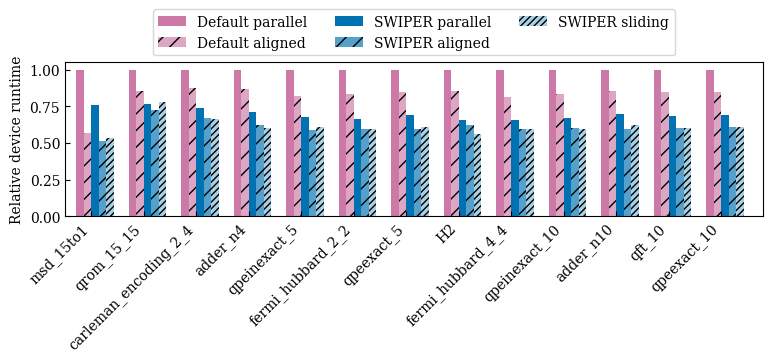

In [13]:
ax, results = plot_data(data_by_config, config, 'speculation_mode', 'scheduling_method', 'device', relative_to={'scheduling_method':'parallel', 'speculation_mode':None})

# plt.yscale('log')
# legend outside on right

handles, labels = ax.get_legend_handles_labels()
# order = [2,3,4,0,1]
order = [0,1,2,3,4]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3)

plt.savefig('notebooks/figures/benchmarks.pdf', bbox_inches='tight')
plt.savefig('notebooks/figures/benchmarks.svg', bbox_inches='tight')
plt.show()

In [15]:
with open(f'{directory}/decoder_dists.json', 'r') as f:
    decoder_dists = json.load(f)

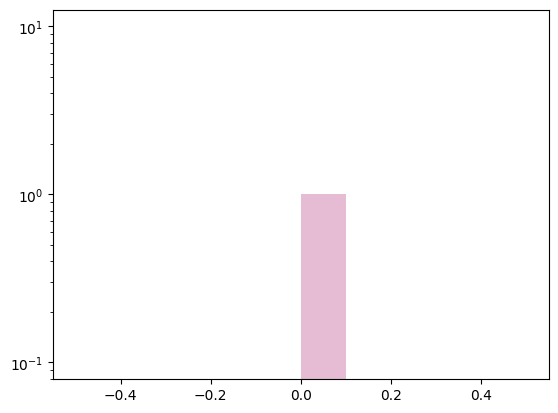

In [157]:
plt.hist([0], color=cmaps[0](0.5))
plt.yscale('log')

In [ ]:
handles[0].set_

{'patches': [<matplotlib.patches.Rectangle at 0x172dc8610>],
 'errorbar': None,
 'datavalues': array([1.]),
 'orientation': 'vertical',
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x172d6f290>,
 '_remove_method': <function list.remove(value, /)>,
 '_label': 'speculation off, parallel'}